In [7]:
import torch.nn as nn
import torch.nn.functional as F


class ProfileBayesClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_profiles, num_classes,p_y):
        super().__init__()
        self.num_profiles = num_profiles
        self.num_classes = num_classes
        self.p_y = p_y
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_profiles)
        )

        # 使用 register_buffer 保持状态但不被训练
        self.register_buffer("count_z_given_y", torch.zeros(num_profiles, num_classes))  # [T, K]

    def update_profile_counts(self, q_z_given_x, y_true):
        """
        使用 soft assignment 更新 profile 频数表：
        q_z_given_x: [B, T], y_true: [B]
        """
        with torch.no_grad():
            B, T = q_z_given_x.shape
            K = self.num_classes
            one_hot_y = F.one_hot(y_true, K).float()  # [B, K]
            # outer product: for each sample, update count[z, y]
            # Resulting shape: [B, T, K]
            contrib = torch.einsum("bt,bk->btk", q_z_given_x, one_hot_y)
            self.count_z_given_y += contrib.sum(dim=0)  # sum over batch

    def compute_p_z_given_y(self):
        # 避免除以 0：加入平滑
        smoothed = self.count_z_given_y + 1e-3
        return smoothed / smoothed.sum(dim=0, keepdim=True)  # [T, K]



    def forward(self, x):
        # q(Z|X)
        profile_logits = self.encoder(x)
        q_z_given_x = F.softmax(profile_logits, dim=1)  # [B, T]

        # Profile 后验
        p_z_given_y = self.compute_p_z_given_y()  # [T, K]

        # 归一化（每行归一）
        p_z = (p_z_given_y * self.p_y.unsqueeze(0)).sum(dim=1)  # shape [T]

        # 构造完整贝叶斯项：P(Z|Y)*P(Y) / P(Z)
        bayes_matrix = (p_z_given_y * self.p_y.unsqueeze(0)) / (p_z.unsqueeze(1) + 1e-9)  # [T, K]

        # 推理公式：P(Y|X) = sum_z P(Y|Z=z) * P(Z=z|X)
        p_y_given_x = q_z_given_x @ bayes_matrix  # shape [B, K]
        return p_y_given_x, q_z_given_x, p_z_given_y

    def predict(self, x):
        p_y_given_x, _, _ = self.forward(x)
        return p_y_given_x

def profile_entropy_regularization(q_z_given_x):
        avg_profile = q_z_given_x.mean(dim=0) + 1e-9
        return -torch.sum(avg_profile * avg_profile.log())

def profile_kl_regularization(q_z_given_x):
    avg_profile = q_z_given_x.mean(dim=0) + 1e-9
    log_avg = avg_profile.log()
    log_uniform = torch.full_like(log_avg, fill_value=torch.log(torch.tensor(1.0 / len(avg_profile))))
    return torch.sum(avg_profile * (log_avg - log_uniform))


import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class GenerativeProfileBayesClassifier(nn.Module):
    def __init__(self, input_dim, num_profiles, num_classes):
        """
        input_dim: X 的维度
        num_profiles: 潜在 profile 数 (T)
        num_classes: 类别数 (K)
        """
        super().__init__()
        self.num_profiles = num_profiles
        self.num_classes = num_classes

        # p(Z) 先验 (Categorical 分布)
        self.logits_pz = nn.Parameter(torch.zeros(num_profiles))  # [T]

        # p(X|Z) = Gaussian(mu_z, diag(sigma^2_z))
        self.mu = nn.Parameter(torch.randn(num_profiles, input_dim))  # [T, D]
        self.logvar = nn.Parameter(torch.zeros(num_profiles, input_dim))  # [T, D]

        # p(Y|Z) = Categorical
        self.logits_y_given_z = nn.Parameter(torch.zeros(num_profiles, num_classes))  # [T, K]

    def p_x_given_z(self, x):
        """
        计算 p(x|z) for all z
        x: [B, D], mu/logvar: [T, D]
        return: [B, T]
        """
        B, D = x.shape
        x_expand = x.unsqueeze(1)  # [B, 1, D]
        mu = self.mu.unsqueeze(0)  # [1, T, D]
        logvar = self.logvar.unsqueeze(0)  # [1, T, D]
        var = logvar.exp()

        log_prob = -0.5 * (((x_expand - mu) ** 2) / var + logvar + math.log(2 * math.pi)).sum(dim=2)
        return log_prob.exp()  # [B, T]

    def forward(self, x):
        """
        返回:
          p_y_given_x: [B, K]
          p_z_given_x: [B, T]
        """
        B = x.size(0)

        # p(z) = softmax(logits_pz)
        p_z = F.softmax(self.logits_pz, dim=0)  # [T]

        # p(x|z)
        p_x_given_z = self.p_x_given_z(x)  # [B, T]

        # p(z|x) ∝ p(x|z) p(z)
        log_posterior = torch.log(p_x_given_z + 1e-9) + torch.log(p_z.unsqueeze(0) + 1e-9)  # [B, T]
        p_z_given_x = F.softmax(log_posterior, dim=1)  # [B, T]

        # p(y|z)
        p_y_given_z = F.softmax(self.logits_y_given_z, dim=1)  # [T, K]

        # p(y|x) = ∑_z p(y|z) p(z|x)
        p_y_given_x = p_z_given_x @ p_y_given_z  # [B, K]

        return p_y_given_x, p_z_given_x, p_y_given_z

    def predict(self, x):
        p_y_given_x, _, _ = self.forward(x)
        return p_y_given_x

    def generate(self, num_samples=10):
        """
        生成样本 (x, y)
        """
        with torch.no_grad():
            # 1. 采样 z ~ p(z)
            p_z = F.softmax(self.logits_pz, dim=0)
            z = torch.multinomial(p_z, num_samples=num_samples, replacement=True)  # [N]

            # 2. 采样 x ~ p(x|z)
            mu = self.mu[z]       # [N, D]
            logvar = self.logvar[z]
            std = (0.5 * logvar).exp()
            eps = torch.randn_like(std)
            x = mu + eps * std

            # 3. 采样 y ~ p(y|z)
            p_y_given_z = F.softmax(self.logits_y_given_z[z], dim=1)  # [N, K]
            y = torch.multinomial(p_y_given_z, num_samples=1).squeeze(1)  # [N]

            return x, y, z


In [64]:
from sklearn.datasets import make_circles, make_moons
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from dbc.utils import compute_prior

# 生成数据
# X, y = datasets.make_blobs(
#     n_samples=[125 * 5, 125 * 2],
#     n_features=2,
#     centers=[(9.5, 10), (10, 9.4)],
#     cluster_std=[[0.6, 0.6], [0.35, 0.3]],
#     shuffle=True
# )
# X, y = make_circles(n_samples=2000, noise=0.05, factor=0.5)
X, y = make_moons(n_samples=2000, noise=0.3)
# 归一化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 分训练集与验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

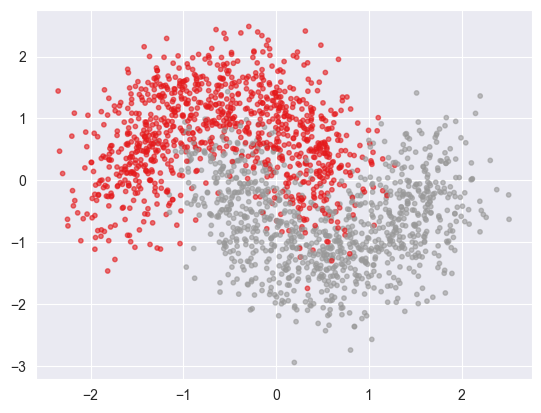

In [52]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.6, s=10)

In [73]:
import matplotlib.pyplot as plt
from dbc.main import KmeansDiscreteBayesianClassifier, DecisionTreeDiscreteBayesianClassifier
from dbc.utils import compute_conditional_risk
from sklearn.metrics import accuracy_score

DBC_kmeans = KmeansDiscreteBayesianClassifier(n_clusters=8)
DBC_kmeans.fit(X_train, y_train)
y_pred = DBC_kmeans.predict(X_val)
conditional_risk = compute_conditional_risk(y_val, y_pred)
print(f'Kmeans Class condition risk: \n{conditional_risk[0]}')
print(f'\nKmeans Acc: \n{accuracy_score(y_val, y_pred)}')

Kmeans Class condition risk: 
[0.22297297 0.0625    ]

Kmeans Acc: 
0.8583333333333333


In [77]:
DBC_DT = DecisionTreeDiscreteBayesianClassifier(max_depth=3)
DBC_DT.fit(X_train, y_train)
y_pred = DBC_DT.predict(X_val)
conditional_risk = compute_conditional_risk(y_val, y_pred)
print(f'DT Class condition risk: \n{conditional_risk[0]}')
print(f'\nDT Acc: \n{accuracy_score(y_val, y_pred)}')

DT Class condition risk: 
[0.14864865 0.09868421]

DT Acc: 
0.8766666666666667


In [55]:
p_y = torch.tensor(compute_prior(y_train, 2), dtype=torch.float32)

# 转成 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

Epoch   1: Train Loss=7.6256, Val Loss=3.4643 | Train Acc=0.5021 | Val Acc=0.4950
Epoch   2: Train Loss=7.6126, Val Loss=3.4504 | Train Acc=0.6543 | Val Acc=0.8217
Epoch   3: Train Loss=7.5412, Val Loss=3.3723 | Train Acc=0.8643 | Val Acc=0.8333
Epoch   4: Train Loss=7.2724, Val Loss=3.1918 | Train Acc=0.8629 | Val Acc=0.8267
Epoch   5: Train Loss=6.8404, Val Loss=2.9999 | Train Acc=0.8621 | Val Acc=0.8400
Epoch   6: Train Loss=6.4928, Val Loss=2.8983 | Train Acc=0.8679 | Val Acc=0.8500
Epoch   7: Train Loss=6.2557, Val Loss=2.8130 | Train Acc=0.8721 | Val Acc=0.8533
Epoch   8: Train Loss=6.0864, Val Loss=2.7467 | Train Acc=0.8764 | Val Acc=0.8550
Epoch   9: Train Loss=5.9397, Val Loss=2.7006 | Train Acc=0.8857 | Val Acc=0.8583
Epoch  10: Train Loss=5.8058, Val Loss=2.6397 | Train Acc=0.8929 | Val Acc=0.8700
Epoch  11: Train Loss=5.6991, Val Loss=2.6037 | Train Acc=0.8971 | Val Acc=0.8733
Epoch  12: Train Loss=5.6060, Val Loss=2.5423 | Train Acc=0.9050 | Val Acc=0.8850
Epoch  13: Train

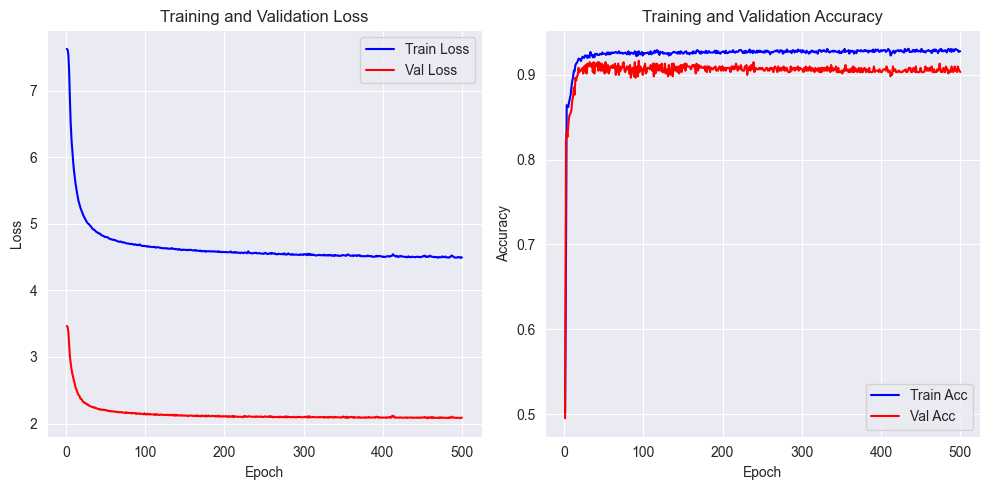

In [61]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


input_dim = 2  # 特征维度
hidden_dim = 64
num_profiles = 8
num_classes = 2

model = ProfileBayesClassifier(input_dim, hidden_dim, num_profiles, num_classes,p_y)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


num_epochs = 500
train_losses = []
val_losses = []  # 添加验证损失列表
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_total_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        p_y_given_x, q_z_given_x, _ = model(X_batch)
        model.update_profile_counts(q_z_given_x, y_batch)
        loss = criterion(p_y_given_x, y_batch) + 0.1 * profile_kl_regularization(q_z_given_x)
        loss.backward()
        optimizer.step()
        train_total_loss += loss.item()

        train_preds = torch.argmax(p_y_given_x, dim=1)
        train_correct += (train_preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_losses.append(train_total_loss)
    train_accuracies.append(train_correct / train_total)

    # 验证阶段
    model.eval()
    val_total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            p_y_given_x = model.predict(X_batch)
            val_loss = criterion(p_y_given_x, y_batch)
            val_total_loss += val_loss.item()

            correct += (torch.argmax(p_y_given_x, dim=1) == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_total_loss)
    acc = correct / total
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1:3d}: Train Loss={train_total_loss:.4f}, Val Loss={val_total_loss:.4f} | Train Acc={train_accuracies[-1]:.4f} | Val Acc={acc:.4f}")

# 绘制训练和验证损失
plt.figure(figsize=(10, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

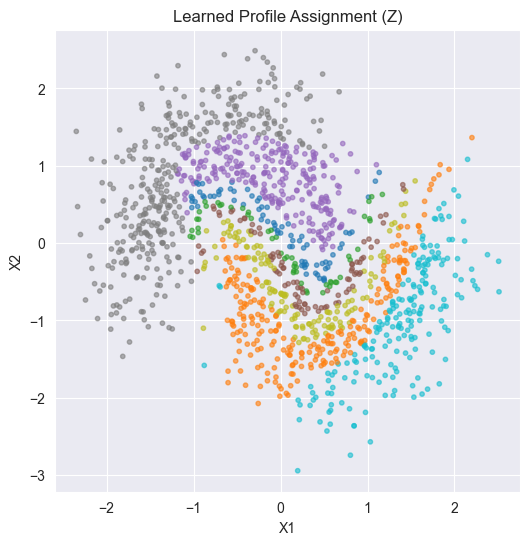

In [57]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    _, q_z_given_x, _ = model(X_train)
    Z_val = torch.argmax(q_z_given_x, dim=1)

plt.figure(figsize=(6, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=Z_val, cmap="tab10", alpha=0.6, s=10)
plt.title("Learned Profile Assignment (Z)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


Epoch   1: Train Loss=7.6105, Val Loss=3.4529 | Train Acc=0.8114 | Val Acc=0.8050
Epoch   2: Train Loss=7.5795, Val Loss=3.4397 | Train Acc=0.8464 | Val Acc=0.8033
Epoch   3: Train Loss=7.5470, Val Loss=3.4262 | Train Acc=0.8457 | Val Acc=0.8050
Epoch   4: Train Loss=7.5142, Val Loss=3.4123 | Train Acc=0.8471 | Val Acc=0.8067
Epoch   5: Train Loss=7.4799, Val Loss=3.3982 | Train Acc=0.8464 | Val Acc=0.8100
Epoch   6: Train Loss=7.4455, Val Loss=3.3835 | Train Acc=0.8486 | Val Acc=0.8167
Epoch   7: Train Loss=7.4095, Val Loss=3.3686 | Train Acc=0.8507 | Val Acc=0.8200
Epoch   8: Train Loss=7.3730, Val Loss=3.3535 | Train Acc=0.8507 | Val Acc=0.8217
Epoch   9: Train Loss=7.3360, Val Loss=3.3381 | Train Acc=0.8529 | Val Acc=0.8217
Epoch  10: Train Loss=7.2985, Val Loss=3.3226 | Train Acc=0.8550 | Val Acc=0.8217
Epoch  11: Train Loss=7.2603, Val Loss=3.3069 | Train Acc=0.8557 | Val Acc=0.8217
Epoch  12: Train Loss=7.2220, Val Loss=3.2912 | Train Acc=0.8564 | Val Acc=0.8217
Epoch  13: Train

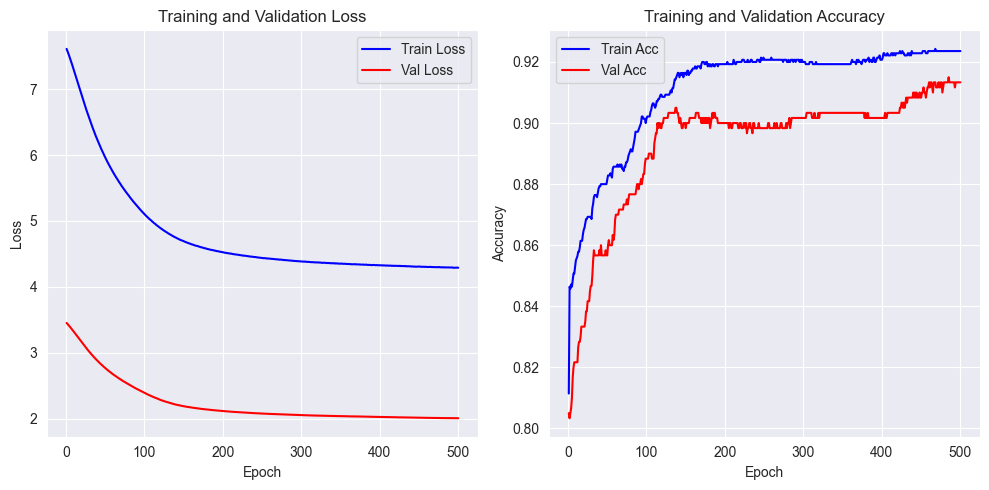

In [58]:
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

input_dim = 2  # 特征维度
num_profiles = 8
num_classes = 2

# 用生成式版本
model = GenerativeProfileBayesClassifier(input_dim, num_profiles, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 500
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_total_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        p_y_given_x, p_z_given_x, p_y_given_z = model(X_batch)

        loss = criterion(p_y_given_x, y_batch)  # 分类损失
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        train_preds = torch.argmax(p_y_given_x, dim=1)
        train_correct += (train_preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_losses.append(train_total_loss)
    train_accuracies.append(train_correct / train_total)

    # 验证阶段
    model.eval()
    val_total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            p_y_given_x, _, _ = model(X_batch)
            val_loss = criterion(p_y_given_x, y_batch)
            val_total_loss += val_loss.item()

            preds = torch.argmax(p_y_given_x, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_total_loss)
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1:3d}: "
          f"Train Loss={train_total_loss:.4f}, Val Loss={val_total_loss:.4f} | "
          f"Train Acc={train_accuracies[-1]:.4f} | Val Acc={val_accuracies[-1]:.4f}")

# 绘制训练和验证曲线
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


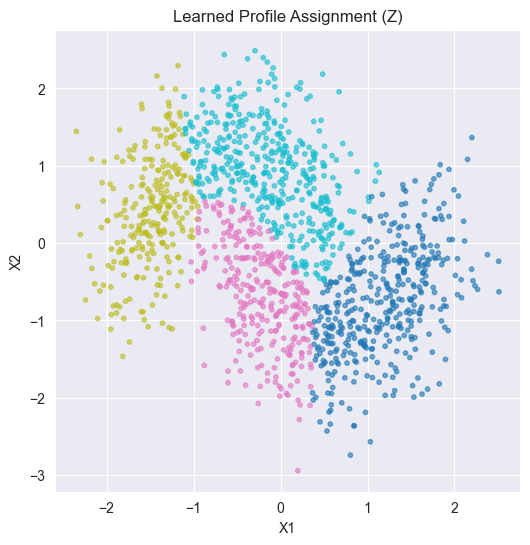

In [59]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    _, q_z_given_x, _ = model(X_train)
    Z_val = torch.argmax(q_z_given_x, dim=1)

plt.figure(figsize=(6, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=Z_val, cmap="tab10", alpha=0.6, s=10)
plt.title("Learned Profile Assignment (Z)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


In [60]:
# # 执行100次实验并绘制性能比较小提琴图
#
# import numpy as np
# import seaborn as sns
# from tqdm import tqdm
#
# # 存储100次实验的结果
# kmeans_accs = []
# dt_accs = []
# nn_accs = []
#
# # 执行100次实验
# for i in tqdm(range(100)):
#     # 重新生成数据
#     X, y = datasets.make_blobs(
#         n_samples=[125 * 5, 125 * 2],
#         n_features=2,
#         centers=[(9.5, 10), (10, 9.4)],
#         cluster_std=[[0.6, 0.6], [0.35, 0.3]],
#         shuffle=True
#     )
#
#     # 归一化
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)
#
#     # 分割数据
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
#
#     # KMeans实验
#     DBC_kmeans = KmeansDiscreteBayesianClassifier(n_clusters=8)
#     DBC_kmeans.fit(X_train, y_train)
#     y_pred_kmeans = DBC_kmeans.predict(X_val)
#     kmeans_acc = accuracy_score(y_val, y_pred_kmeans)
#     kmeans_accs.append(kmeans_acc)
#
#     # 决策树实验
#     DBC_DT = DecisionTreeDiscreteBayesianClassifier(max_depth=3)
#     DBC_DT.fit(X_train, y_train)
#     y_pred_dt = DBC_DT.predict(X_val)
#     dt_acc = accuracy_score(y_val, y_pred_dt)
#     dt_accs.append(dt_acc)
#
#     # 神经网络实验
#     p_y = torch.tensor(compute_prior(y_train, 2), dtype=torch.float32)
#     X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#     y_train_tensor = torch.tensor(y_train, dtype=torch.long)
#     X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
#     y_val_tensor = torch.tensor(y_val, dtype=torch.long)
#
#     # 创建数据加载器
#     train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
#
#     # 初始化模型
#     model = ProfileBayesClassifier(2, 64, 8, 2, p_y)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     criterion = nn.CrossEntropyLoss()
#
#     # 训练模型
#     for epoch in range(100):
#         model.train()
#         for X_batch, y_batch in train_loader:
#             optimizer.zero_grad()
#             p_y_given_x, q_z_given_x, _ = model(X_batch)
#             model.update_profile_counts(q_z_given_x, y_batch)
#             loss = criterion(p_y_given_x, y_batch) + 0.1 * profile_kl_regularization(q_z_given_x)
#             loss.backward()
#             optimizer.step()
#
#     # 评估神经网络模型
#     model.eval()
#     with torch.no_grad():
#         y_pred_nn = torch.argmax(model.predict(X_val_tensor), dim=1)
#         nn_acc = accuracy_score(y_val_tensor, y_pred_nn)
#         nn_accs.append(nn_acc)
#
# # 创建绘图数据
# plot_data = {
#     'KMeans': kmeans_accs,
#     'Decision Tree': dt_accs,
#     'Neural Network': nn_accs
# }
#
# # 设置绘图样式
# plt.figure(figsize=(10, 6))
# sns.violinplot(data=plot_data)
# plt.title('Performance Comparison of Different Models')
# plt.ylabel('Accuracy')
# plt.grid(True, alpha=0.3)
# plt.show()
#
# # 打印统计信息
# print("模型性能统计信息：")
# print("\nKMeans:")
# print(f"平均准确率: {np.mean(kmeans_accs):.4f}")
# print(f"标准差: {np.std(kmeans_accs):.4f}")
#
# print("\nDecision Tree:")
# print(f"平均准确率: {np.mean(dt_accs):.4f}")
# print(f"标准差: {np.std(dt_accs):.4f}")
#
# print("\nNeural Network:")
# print(f"平均准确率: {np.mean(nn_accs):.4f}")
# print(f"标准差: {np.std(nn_accs):.4f}")